# PREDICTING STOCK PRICE


There are 2 common ways to analyze a stock:

    1.Fundamental Analysis: Fundamental analysis concentrates on data from sources, including financial records, economic reports,company assets, and market share. To conduct fundamental analysis on a public company or sector, investors and 
    analysts typically analyze the metrics on a company’s financial statements – balance sheet, income statement, cash flow statement, and footnotes. 
    2.Technical Analysis: Technical analysis focuses on the study of past market action to predict future price movement.          Technical analysts analyze the financial market as a whole and are primarily concerned with price and volume, 
    as well as the demand and supply factors that move the market.

In [191]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs
import plotly.graph_objects as go  #plot candlestick of stockprice
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')  #ignore warning                 # To ignore the warnings warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression

In [192]:
#Import data (split data into train set and test set)
VIC_train=pd.read_csv("C:/Users/DELL/Desktop/VIC_train.csv") #training set  20/9/2007-31/7/2017  (d-m-y)
VIC_test=pd.read_csv("C:/Users/DELL/Desktop/VIC_test.csv") #test set  1/8/2018-13/12/2019
VIC=pd.read_csv("C:/Users/DELL/Desktop/VIC.csv") #the whole data set, which 80.5% is for training, 19.5%  is for testing

#
#X = VIC.values
#train_size = int(len(X) * 0.805)
#train, test = X[0:train_size], X[train_size:len(X)]
#print('Observations: %d' % (len(X)))
#print('Training Observations: %d' % (len(train)))
#print('Testing Observations: %d' % (len(test)))

#make a copy of train and test data so that even if we do changes in these dataset we will not lose the original dataset
train=VIC_train.copy()
test=VIC_test.copy()
VIC_new =VIC.copy()

#change the data type to datetime format
train['Date'] = pd.to_datetime(train.Date,format='%m/%d/%Y') 
test['Date'] = pd.to_datetime(test.Date,format='%m/%d/%Y') 
VIC_train['Date'] = pd.to_datetime(VIC_train.Date,format='%m/%d/%Y') 
VIC_test['Date'] = pd.to_datetime(VIC_test.Date,format='%m/%d/%Y')
VIC['Date']=pd.to_datetime(VIC.Date,format='%m/%d/%Y')
VIC_new['Date']=pd.to_datetime(VIC_new.Date,format='%m/%d/%Y')

#Check loaded data.
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 10 columns):
Date                    2454 non-null datetime64[ns]
Open                    2454 non-null int64
High                    2454 non-null int64
Low                     2454 non-null int64
Closed Price            2435 non-null float64
 Volume                 2454 non-null int64
Buy Sell                2454 non-null int64
Vn-index                2454 non-null float64
Dowjones                2454 non-null float64
Private trade volume    2454 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 191.8 KB
None


,Date,Open,High,Low,Closed Price,Volume,Buy Sell,Vn-index,Dowjones,Private trade volume
0,2007-09-20,125000,131000,130000,131000.0,794790,158820,963.61,13815.55957,0
1,2007-09-21,131000,137000,135000,137000.0,1224660,641840,958.67,13766.70020,0
2,2007-09-24,137000,143000,143000,143000.0,551130,1024220,975.82,13820.19043,20000
3,2007-09-25,143000,150000,148000,150000.0,962110,813400,1009.88,13759.05957,0
4,2007-09-26,150000,157000,154000,157000.0,781900,155500,1015.91,13778.65039,0


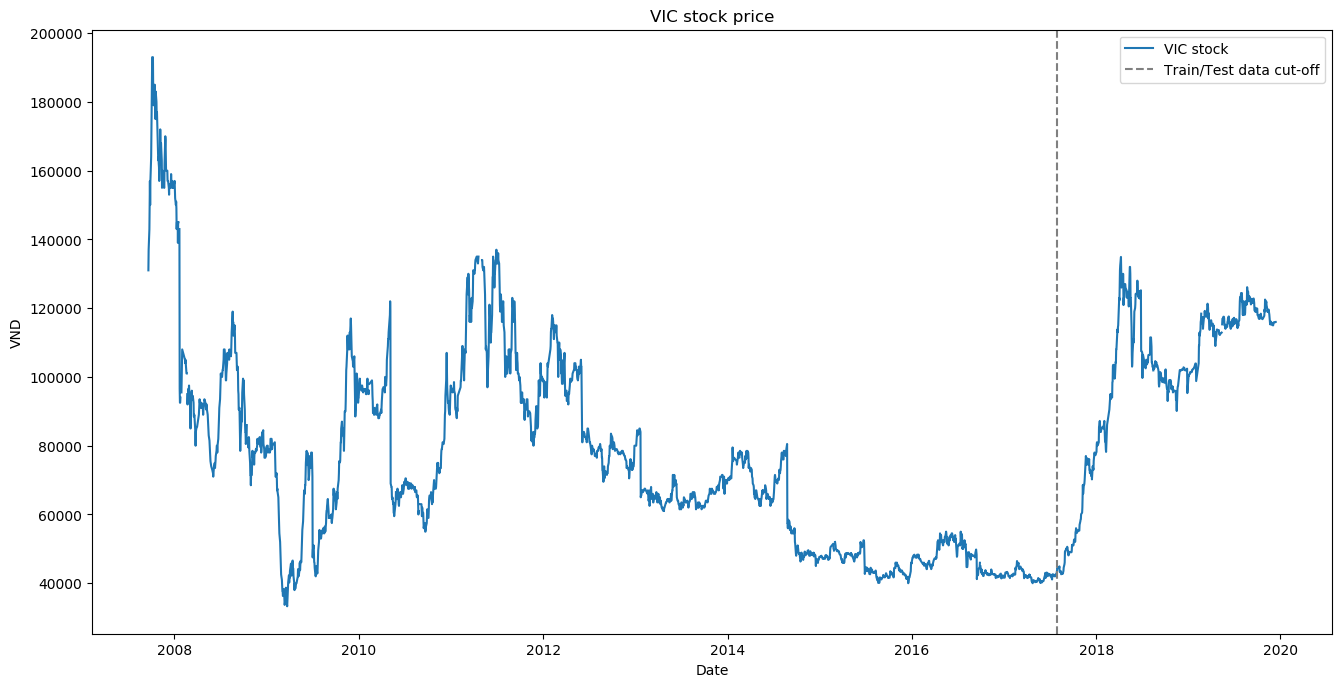

Number of training days:  2454
Number of test days:  594


In [193]:
import matplotlib.pyplot as plt
#draw graph of stock price
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(VIC_new['Date'], VIC_new['Closed Price'], label='VIC stock')
plt.axvline(pd.Timestamp('2017-07-31'),linestyle='--',color='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('VND')
plt.title('VIC stock price')
plt.legend(loc='best')
plt.show()

#number of training days, test days
num_training_days = len(train['Date'])
num_test_days=len(test)
print('Number of training days: ', num_training_days)
print('Number of test days: ', num_test_days)

In [194]:
import plotly.graph_objects as go 
#visualizing stock price in candlestick shape 
fig = go.Figure(data=[go.Candlestick(x=VIC_new['Date'],
                open=VIC_new['Open'],
                high=VIC_new['High'],
                low=VIC_new['Low'],
                close=VIC_new['Closed Price'])])
fig.update_layout(
    title='VIC candlestick',
    yaxis_title='VIC Stock')
fig.show()

Closed Price            1.000000
High                    0.999252
Low                     0.999180
Open                    0.997841
Buy Sell                0.153434
Vn-index                0.090779
Private trade volume   -0.115690
 Volume                -0.340417
Dowjones               -0.474496
Name: Closed Price, dtype: float64


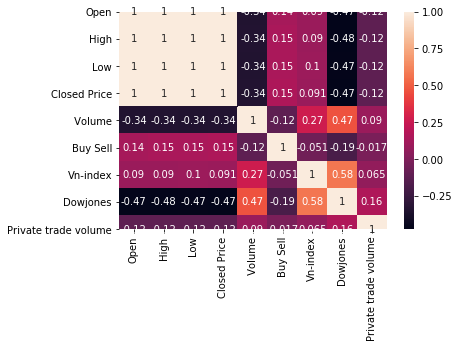

In [195]:
#Correlation matrix
import seaborn as sn
corr_matrix = train.corr()
#each attribute correlates with the Closed Price:
print(corr_matrix["Closed Price"].sort_values(ascending=False))
corr_matrix.style.background_gradient(cmap='coolwarm')
sn.heatmap(corr_matrix, annot=True)

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation. When the coefficient is close to –1, it means
that there is a strong negative correlation. Finally, coefficients close to zero mean that there is no
linear correlation.

# TRAINING MODEL

There are some NaN values in the data set (Closed Price) so we need to fill the data first. I will set the NaN values equal to the mean of the column of Closed Price.

In [196]:
#Fill the data
median1 = train["Closed Price"].median()
train["Closed Price"]=train["Closed Price"].fillna(median1)

median2 = test["Closed Price"].median()
test["Closed Price"]=test["Closed Price"].fillna(median2)

median3=VIC_new['Closed Price'].median()
VIC_new['Closed Price']=VIC_new['Closed Price'].fillna(median3)

#Check if is there any NaN values:
print(np.isnan(train['Closed Price']))
print(np.isnan(test['Closed Price']))
print(np.isnan(VIC['Closed Price']))

0       False
1       False
2       False
3       False
4       False
        ...  
2449    False
2450    False
2451    False
2452    False
2453    False
Name: Closed Price, Length: 2454, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
589    False
590    False
591    False
592    False
593    False
Name: Closed Price, Length: 594, dtype: bool
0       False
1       False
2       False
3       False
4       False
        ...  
3043    False
3044    False
3045    False
3046    False
3047    False
Name: Closed Price, Length: 3048, dtype: bool


# Linear regression

In [264]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

#drop Date, Closed Price
train_attribute=np.array(train.drop(['Date','Closed Price'],axis=1))
train_price=np.array(train['Closed Price']).reshape(-1,1)
test_attribute=np.array(test.drop(['Date','Closed Price'],axis=1))
test_price=np.array(test['Closed Price']).reshape(-1,1)

#Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_attribute_sc=scaler.fit_transform(train_attribute)
test_attribute_sc=scaler.fit_transform(test_attribute)
train_price_sc=scaler.fit_transform(train_price)
test_price_sc=scaler.fit_transform(test_price)

#Linear regression
reg = linear_model.LinearRegression()
reg.fit(train_attribute_sc, train_price_sc)
test_prediction=reg.predict(test_attribute_sc)
lin_mse = mean_squared_error(test_price_sc, test_prediction)
lin_rmse = np.sqrt(lin_mse)  #RSME of test set not on training set
print('The coefficient is: ',reg.coef_)
print('The RMSE is: ',lin_rmse)

The coefficient is:  [[-8.96653563e-02  3.77494479e-01  2.59352395e-01 -3.12334963e-04
   4.14961211e-03  5.53606337e-03 -5.12633487e-03  1.12206101e-03
   4.37188869e-01]]
The RMSE is:  0.05244311500280458


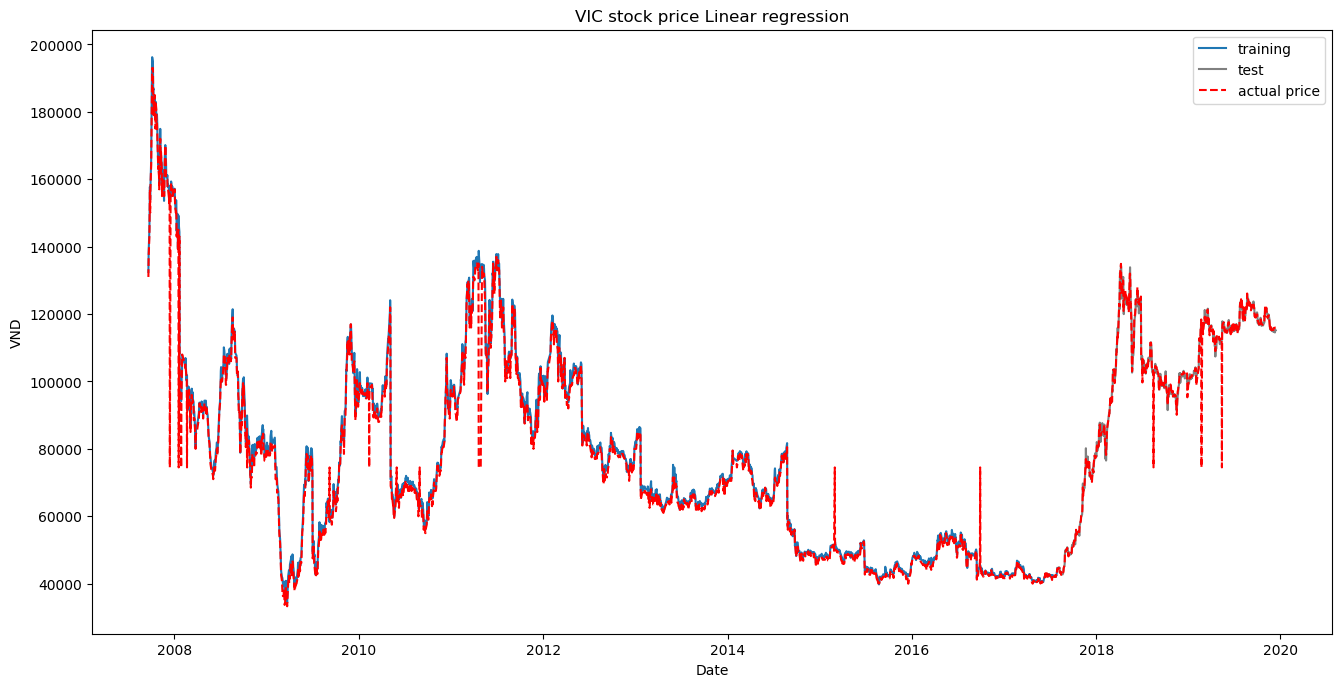

In [198]:
#draw graph of stock price,we want to draw graph with original price not the scaled price
reg = linear_model.LinearRegression()
reg.fit(train_attribute, train_price)
reg.fit(test_attribute, test_price)
train['predict price']=reg.predict(train_attribute)
test['predict price']=reg.predict(test_attribute)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(train['Date'], train['predict price'], label='training')
plt.plot(test['Date'],test['predict price'],label='test', color='gray')
plt.plot(VIC_new['Date'], VIC_new['Closed Price'],label='actual price',color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('VND')
plt.title('VIC stock price Linear regression')
plt.legend(loc='best')
plt.show()
#test['predict price'].to_csv("C:/Users/DELL/Desktop/train.csv")


WOW! The model works so well! Normally linear regression will not give a good result for time series prediction however in this case it worked quite well. It might be because we chose quite good features.

# Lasso regression

In [199]:
#Lets try Lasso
reg1 = linear_model.Lasso(alpha=0.00001)
reg1.fit(train_attribute_sc, train_price_sc)
test_prediction=reg1.predict(test_attribute_sc)
lasso_mse = mean_squared_error(test_price_sc, test_prediction)
lasso_rmse = np.sqrt(lasso_mse)
print('The coefficient is: ',reg1.coef_)
print('The RMSE is: ',lasso_rmse)

The coefficient is:  [-0.14442894  0.8190111   0.30872061 -0.00135954  0.00711186  0.00271421
 -0.00642559  0.00092996]
The RMSE is:  0.054527499048374985


We could see that the RSME of Lasso is greater than Linear regression. When I decrease the value of alpha the RSME decreses at the same time thats why I chose the value of alpha quite small. we will optimize alpha later on.

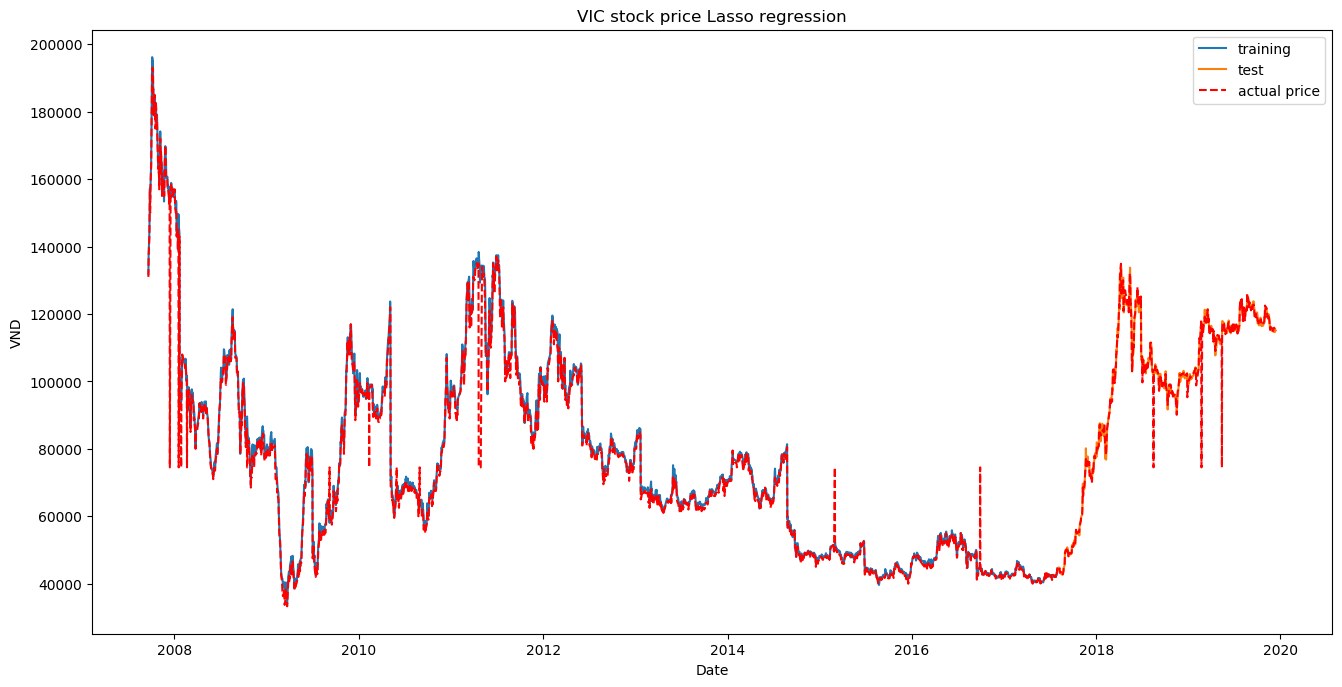

In [200]:
#draw graph of stock price
reg1 = linear_model.Lasso(alpha=0.00001)
reg1.fit(train_attribute, train_price)
reg1.fit(test_attribute, test_price)
train['predict price']=reg1.predict(train_attribute)
test['predict price']=reg1.predict(test_attribute)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(train['Date'], train['predict price'], label='training')
plt.plot(test['Date'],test['predict price'],label='test')
plt.plot(VIC_new['Date'], VIC_new['Closed Price'],label='actual price',color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('VND')
plt.title('VIC stock price Lasso regression')
plt.legend(loc='best')
plt.show()

# Ridge Regression

In [201]:
from sklearn.linear_model import Ridge
reg2 = linear_model.Ridge(alpha=0.00001,solver='cholesky')
reg2.fit(train_attribute_sc, train_price_sc)
test_prediction=reg2.predict(test_attribute_sc)
ridge_mse = mean_squared_error(test_price_sc, test_prediction)
ridge_rmse = np.sqrt(ridge_mse)
print('The coefficient is: ',reg2.coef_)
print('The RMSE is: ',ridge_rmse)

The coefficient is:  [[-1.97862935e-01  7.18531069e-01  4.62525173e-01 -4.75949710e-04
   6.27269261e-03  1.61665115e-03 -7.45614062e-03  1.07023284e-03]]
The RMSE is:  0.05406624405481135


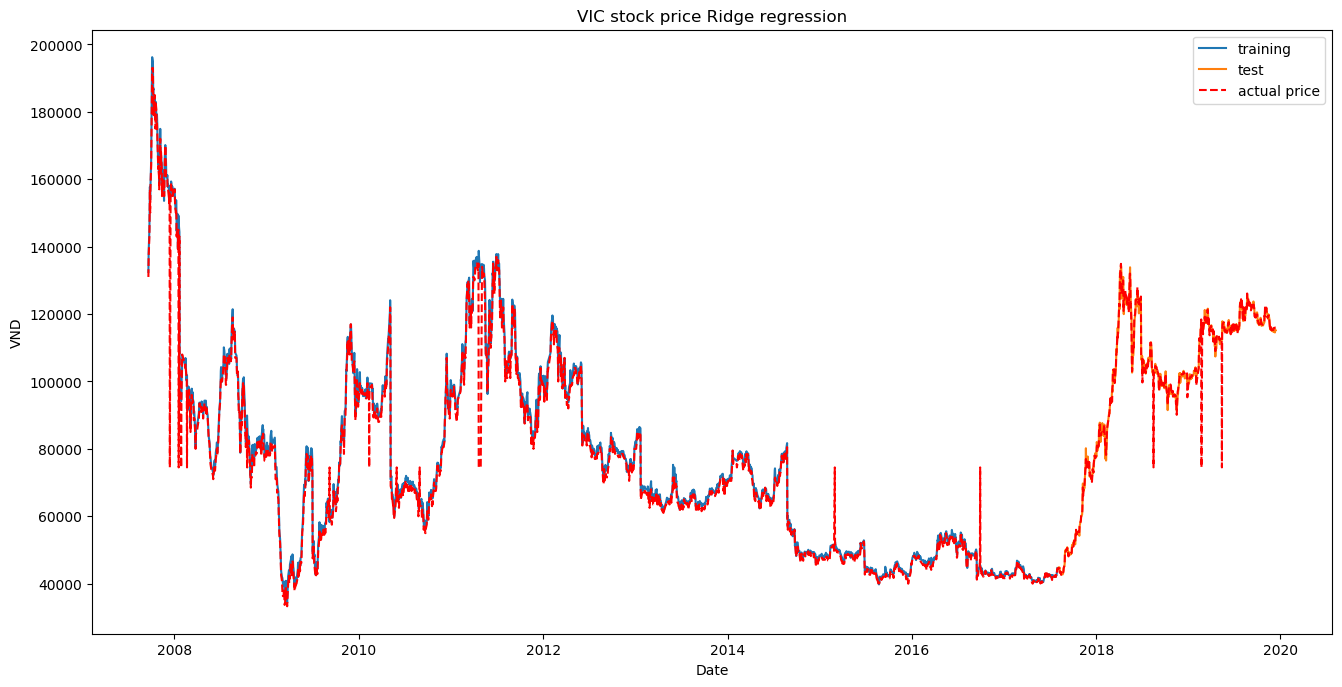

In [202]:
#draw graph of stock price
reg2 = linear_model.Ridge(alpha=0.00001,solver='cholesky')
reg2.fit(train_attribute, train_price)
reg2.fit(test_attribute, test_price)
train['predict price']=reg2.predict(train_attribute)
test['predict price']=reg2.predict(test_attribute)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(train['Date'], train['predict price'], label='training')
plt.plot(test['Date'],test['predict price'],label='test')
plt.plot(VIC_new['Date'], VIC_new['Closed Price'],label='actual price',color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('VND')
plt.title('VIC stock price Ridge regression')
plt.legend(loc='best')
plt.show()

# Elastic Net Regression

In [203]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
reg3 = linear_model.ElasticNet(alpha=0.00001, l1_ratio=0.1)
reg3.fit(train_attribute_sc, train_price_sc)
test_prediction=reg3.predict(test_attribute_sc)
ridge_mse = mean_squared_error(test_price_sc, test_prediction)
ridge_rmse = np.sqrt(ridge_mse)
print('The coefficient is: ',reg3.coef_)
print('The RMSE is: ',ridge_rmse)

The coefficient is:  [-0.14752317  0.8196389   0.31117634 -0.00136495  0.00708193  0.00272022
 -0.00645945  0.00094134]
The RMSE is:  0.05451541439187776


# Randomforest

In [204]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=1000, criterion='mse',random_state=True)
forest_reg.fit(train_attribute_sc, train_price_sc)
test_prediction=forest_reg.predict(test_attribute_sc)
forest_mse = mean_squared_error(test_price_sc, test_prediction)
forest_rmse = np.sqrt(forest_mse)
print('The coefficient is: ',forest_reg.feature_importances_)
print('The RMSE is: ',forest_rmse)

The coefficient is:  [9.21145942e-02 2.37360030e-01 6.32691685e-01 5.26969480e-03
 1.90924811e-03 2.70453042e-02 3.49232263e-03 1.17121300e-04]
The RMSE is:  0.30913900220500357


We could see that the RMSE of Linear regression is the smallest so lets randomly splits the training set into distinct
subsets called folds, then it trains and evaluates the linear regression 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores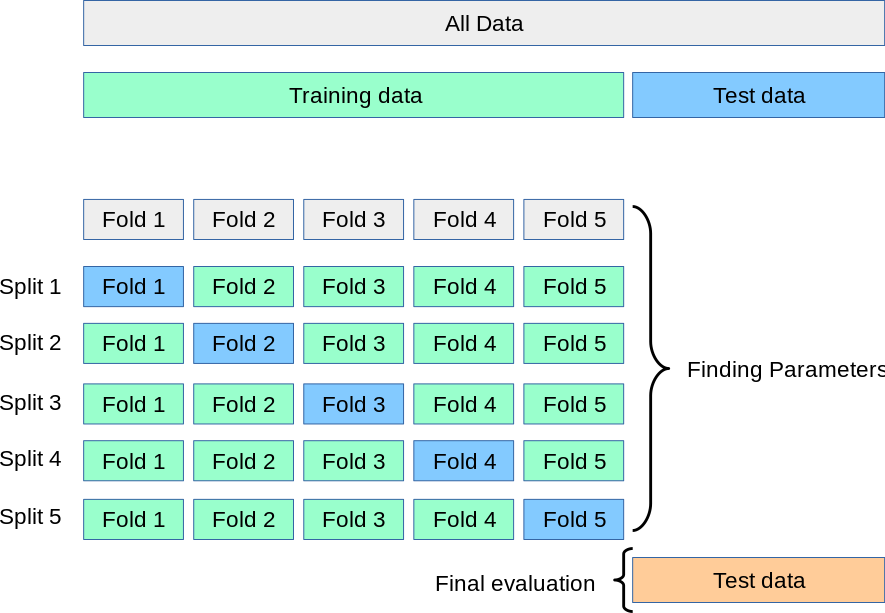

In [205]:
from sklearn.model_selection import cross_val_score
reg = linear_model.LinearRegression()
scores = cross_val_score(reg, train_attribute_sc, train_price_sc,
            scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores.mean()  #rmse on the training validation test, not on the test set yet

0.10643708501769196

It's can be seen that the randomforest is not working well, but Linear, Lasso and Ridge instead. Now lets finetune our model. In Lasso regression, alpha is hyperparameter(a hyperparameter is a parameter whose value is set before the learning process begins, ex: in random forest the hyperparameter should be number of estimator, max_feature, ....). As you can see, in Lasspo regression I chose alpha=0.00001, I just chose it randomly so now lets try to find the optimized value of alpha which could make our model better and see if it could work better than linear regression or not. There are several ways to finetune our model such as: Gridsearch, Randomized search, Ensemble method,...In this case, I would choose GridsearchCV.  

In [206]:
from sklearn.model_selection import GridSearchCV
regr_lasso =linear_model.Lasso()
param_grid=[{'alpha':[0.00001,1]}]
grid_search=GridSearchCV(regr_lasso, param_grid, cv=1000 , scoring='neg_mean_squared_error')
grid_search.fit(train_attribute_sc, train_price_sc)
grid_search.best_estimator_

#final_model =grid_search.best_estimator_
#test_price_prediction=final_model.predict(test_attribute_sc)
#final_mse = mean_squared_error(test_price_sc, test_price_prediction)
#final_rmse = np.sqrt(final_mse) 
#final_rmse

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

So we could see that the best value for alpha we should choose is 0.00005

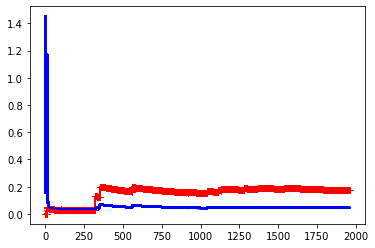

In [207]:
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, train_attribute_sc, train_price_sc):   
    train_attribute_sc_train, train_attribute_sc_val, train_price_sc_train, train_price_sc_val = train_test_split(train_attribute_sc, train_price_sc, test_size=0.2)    
    train_errors, val_errors = [], []    
    for m in range(1, len(train_attribute_sc_train)):        
        model.fit(train_attribute_sc_train[:m], train_price_sc_train[:m])        
        train_price_train_predict = model.predict(train_attribute_sc_train[:m])       
        train_price_val_predict = model.predict(train_attribute_sc_val)        
        train_errors.append(mean_squared_error(train_price_train_predict, train_price_sc_train[:m]))        
        val_errors.append(mean_squared_error(train_price_val_predict, train_price_sc_val))    
        plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="train")    
        plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="val") 
lin_reg = LinearRegression() 
plot_learning_curves(lin_reg, train_attribute_sc, train_price_sc)

# TIME SERIES

Lets first check the stationary of stock price. We will use Dickey-Fuller Test to check. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. if not then we have to make it staionary then use ARIMA to forecast stock price.

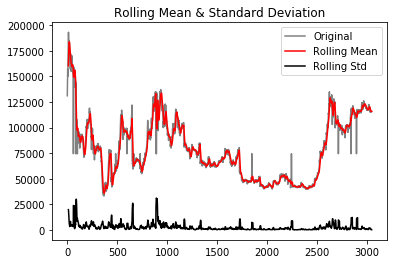

Results of Dickey-Fuller Test:
Test Statistic                   -3.517565
p-value                           0.007547
#Lags Used                       24.000000
Number of Observations Used    3023.000000
Critical Value (1%)              -3.432515
Critical Value (5%)              -2.862497
Critical Value (10%)             -2.567279
dtype: float64


In [208]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    df = pd.DataFrame(timeseries)
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='gray',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
from matplotlib.pylab import rcParams 
#rcParams['figure.figsize'] = 20,10
test_stationarity(VIC_new['Closed Price'])

We have seen that the Test statistic is always less than the critical value so we can conclude that our model is timeseries.

# ARIMA

First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters. To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

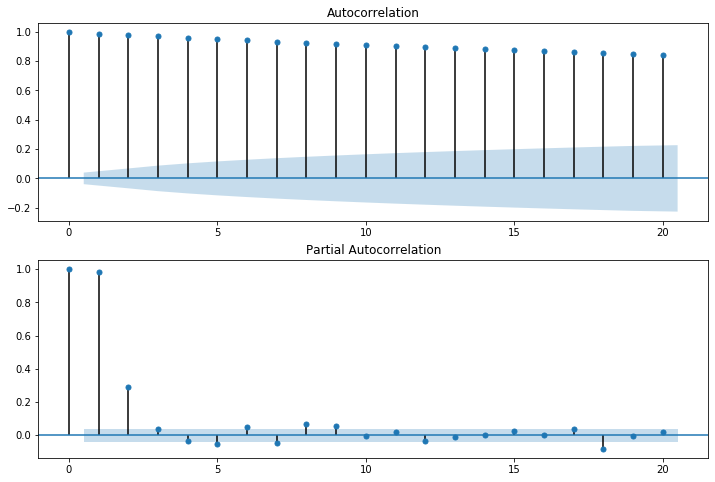

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['Closed Price'], lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['Closed Price'], lags=20, ax=ax2)

We could observe that the ACF does not reach the upper  confidence interval so lets try to make the data more stationaryby eleminating the trend and seasonality. To do that, I would use the first order Differencing – taking the differece with a particular time lag

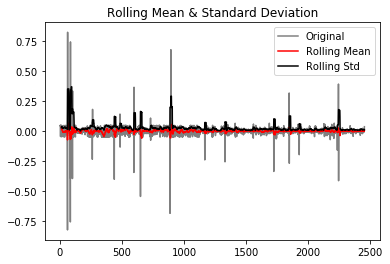

Results of Dickey-Fuller Test:
Test Statistic                -1.076731e+01
p-value                        2.433976e-19
#Lags Used                     2.400000e+01
Number of Observations Used    2.428000e+03
Critical Value (1%)           -3.433046e+00
Critical Value (5%)           -2.862731e+00
Critical Value (10%)          -2.567404e+00
dtype: float64


In [213]:
price_log = np.log(train['Closed Price'])
price_log_diff=price_log-price_log.shift()
price_log_diff.dropna(inplace=True)
test_stationarity(price_log_diff)

we can see that the Test statistic is much less than critical value

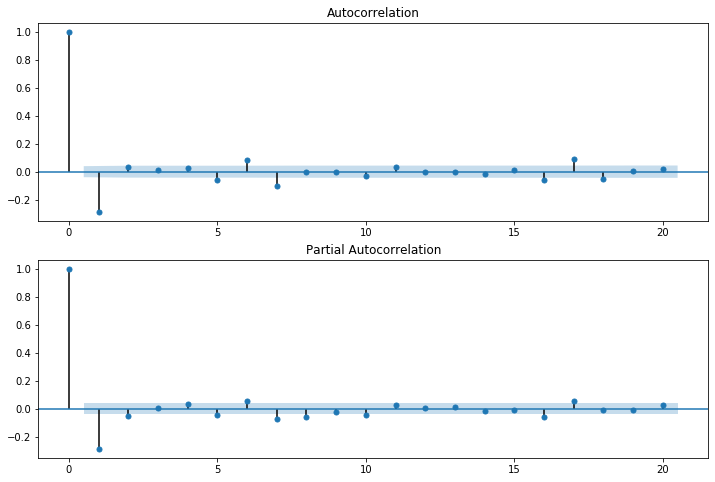

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(price_log_diff, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(price_log_diff, lags=20, ax=ax2)

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=2.
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=2.
d=1 since the first difference make the data stationary

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

# AR model

Text(0.5, 1.0, 'AR RMSE: 0.0506')

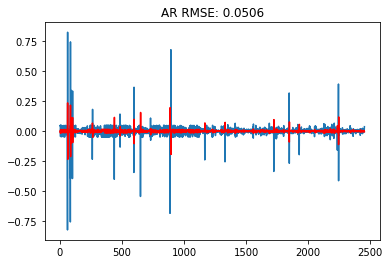

In [316]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(price_log, order=(1, 1, 0))  
results_AR = model.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR RMSE: %.4f'% (np.sqrt(sum((results_AR.fittedvalues-price_log_diff)**2)/np.array(price_log_diff).shape[0])))

Text(0.5, 1.0, 'MA RMSE: 0.0506')

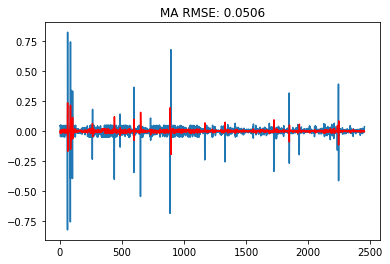

In [313]:
model1 = ARIMA(price_log, order=(0, 1, 1))  
results_MA = model1.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA RMSE: %.4f'% (np.sqrt(sum((results_MA.fittedvalues-price_log_diff)**2)/np.array(price_log).shape[0])))

Text(0.5, 1.0, 'ARIMA RMSE: 0.0506')

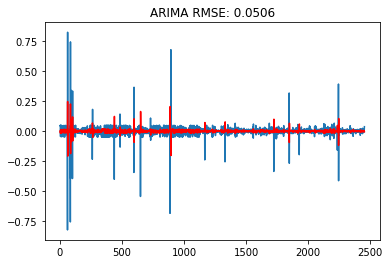

In [312]:
model2 = ARIMA(price_log, order=(1,1,1))  
results_ARIMA = model2.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA RMSE: %.4f'% (np.sqrt(sum((results_ARIMA.fittedvalues-price_log_diff)**2)/np.array(price_log).shape[0])))

In [299]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Closed Price   No. Observations:                 2453
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3840.087
Method:                       css-mle   S.D. of innovations              0.051
Date:                Mon, 23 Dec 2019   AIC                          -7672.174
Time:                        15:12:30   BIC                          -7648.954
Sample:                             1   HQIC                         -7663.736
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0005      0.001     -0.597      0.551      -0.002       0.001
ar.L1.D.Closed Price    -0.1435      0.064     -2.255      0.024      -0.268      -0.019
ma.L1.D.Clos

In [300]:
prediction_ARIMA = results_ARIMA.forecast(steps=594)[0]
price_prediction_ARIMA=np.exp(prediction_ARIMA)  #convert price_log to original price
RMSE=np.sqrt(mean_squared_error(price_prediction_ARIMA, test['Closed Price']))
print('RMSE is: ', RMSE)

RMSE is:  66938.41359262865


The RMSE is quite high, ARIMA does not work well in this case. Lets try to finetune our hyperparameters(p,d,q) by using Grid search

In [317]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
def evaluate_models(dataset, p_values, d_values, q_values):
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                model3=ARIMA(price_log, order=(p,d,q))  
                results_ARIMA1=model3.fit(disp=0)
                mse=np.sqrt(sum((results_ARIMA1.fittedvalues-price_log_diff)**2))
            print('ARIMA%s MSE%s' %(order,mse))
p_values = [1,2,3,4,5,6]
d_values = range(1,2)
q_values = range(1,3)
evaluate_models(price_log, p_values, d_values, q_values)

ARIMA(1, 1, 2) MSE2.50384519424465
ARIMA(2, 1, 2) MSE2.5036655262567353
ARIMA(3, 1, 2) MSE2.4974795817230495
ARIMA(4, 1, 2) MSE2.49300896580018
ARIMA(5, 1, 2) MSE2.493427033742138
ARIMA(6, 1, 2) MSE2.4823527049592817


So obviously (p,d,q)=(6,1,2) will give the smallest MSE. lets try it in our model again:

Text(0.5, 1.0, 'AR RMSE: 0.0504')

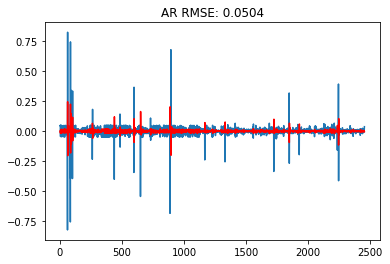

In [318]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(price_log, order=(6, 1, 0))  
results_AR = model.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR RMSE: %.4f'% (np.sqrt(sum((results_AR.fittedvalues-price_log_diff)**2)/np.array(price_log_diff).shape[0])))

Text(0.5, 1.0, 'MA RMSE: 0.0506')

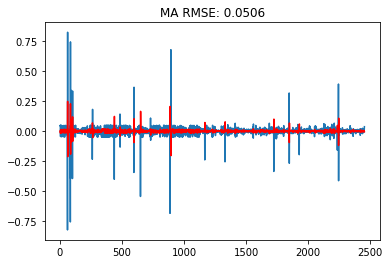

In [320]:
model1 = ARIMA(price_log, order=(0, 1, 2))  
results_MA = model1.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA RMSE: %.4f'% (np.sqrt(sum((results_MA.fittedvalues-price_log_diff)**2)/np.array(price_log).shape[0])))

Text(0.5, 1.0, 'ARIMA RMSE: 0.0501')

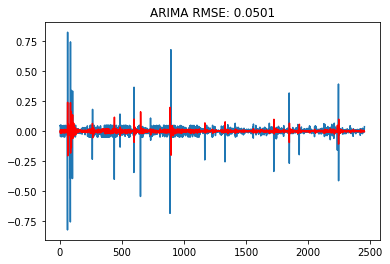

In [321]:
model2 = ARIMA(price_log, order=(6,1,2))  
results_ARIMA = model2.fit(disp=0)  
plt.plot(price_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA RMSE: %.4f'% (np.sqrt(sum((results_ARIMA.fittedvalues-price_log_diff)**2)/np.array(price_log).shape[0])))

In [323]:
#ARIMA gives the best result of RMSE
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Closed Price   No. Observations:                 2453
Model:                 ARIMA(6, 1, 2)   Log Likelihood                3861.955
Method:                       css-mle   S.D. of innovations              0.050
Date:                Mon, 23 Dec 2019   AIC                          -7703.910
Time:                        15:21:09   BIC                          -7645.859
Sample:                             1   HQIC                         -7682.814
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0004      0.001     -0.563      0.574      -0.002       0.001
ar.L1.D.Closed Price    -1.3655      0.053    -25.776      0.000      -1.469      -1.262
ar.L2.D.Clos

In [324]:
prediction_ARIMA = results_ARIMA.forecast(steps=594)[0]
price_prediction_ARIMA=np.exp(prediction_ARIMA)  #convert price_log to original price
RMSE=np.sqrt(mean_squared_error(price_prediction_ARIMA, test['Closed Price']))
print('RMSE is: ', RMSE)

RMSE is:  66796.99473202751


our model is working better however the RMSE is still so high so actually ARIMA is not an ideally model in this case.

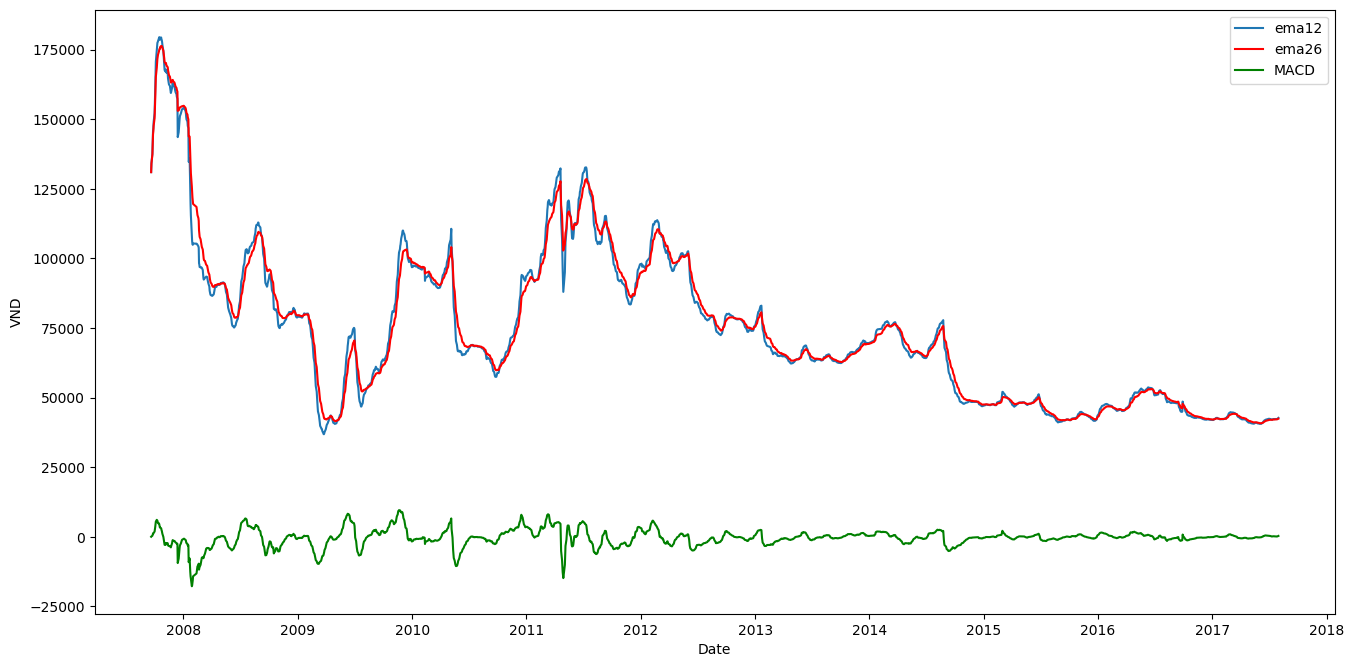

In [348]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

df=pd.DataFrame(train['Closed Price'])
train['26 ema'] = df.ewm(span=26).mean()
train['12 ema'] = df.ewm(span=12).mean()
train['MACD'] = (train['12 ema'] - train['26 ema'])
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(train['Date'], train['12 ema'], label='ema12')
plt.plot(train['Date'], train['26 ema'], label='ema26', color='red')
plt.plot(train['Date'], train['MACD'], label='MACD', color='green')
#plt.plot(VIC_new['Date'], VIC_new['Closed Price'], label='price',color='green')
plt.xlabel('Date')
plt.ylabel('VND')
plt.legend(loc='best')
plt.show()